In [0]:
# Clone the entire repo.
!git clone -l -s https://github.com/mohamedScikitLearn/Facial_expression face
%cd face
!ls

Cloning into 'face'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
/content/face
CK.zip	jaffe.zip


In [0]:
!!unzip CK.zip

In [0]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50


Using TensorFlow backend.


In [0]:
print("The emotion classes are : ",os.listdir("../face/CK+48/"))

The emotion classes are :  ['disgust', 'sadness', 'anger', 'surprise', 'fear', 'contempt', 'happy']


In [0]:
data_path = '../face/CK+48/'
labels = os.listdir('../face/CK+48/')
train_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              zoom_range=0.15,
                              validation_split=0.1)


# Nouvelle section

In [0]:
IMG_SIZE = 224
batch_size = 36
train_data_dir = '../face/CK+48/'
validation_data_dir = '../face/CK+48/'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=36,
    subset='training',
    class_mode='categorical')
valid_X, valid_Y = next(train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=94,
    subset='validation',
    class_mode='categorical'))

Found 887 images belonging to 7 classes.
Found 94 images belonging to 7 classes.


In [0]:
x_train,y_train=next(train_generator)

In [0]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
map_characters1 = {0:'contempt', 1:'anger', 2:'fear', 3:'happy', 4:'surprise', 5:'disgust', 6:'sadness'}


In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
 

In [0]:
input_shape=( 224, 224, 3)




model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(BatchNormalization())

model.add(Conv2D(412, (5, 5), padding='same', activation = 'relu'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))
 
model.summary()
#Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

W0825 12:46:27.732305 139691114162048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 12:46:27.777575 139691114162048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 12:46:27.783989 139691114162048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 12:46:27.810278 139691114162048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0825 12:46:27.823224 139691114162048 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 412)       330012    
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 412)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 412)       1648      
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 412)       0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list1 = [checkpoint]
#callbacks_list = callbacks_list1+[keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1)]


In [0]:
history=model.fit_generator(train_generator,
                            steps_per_epoch = 887/36,
                            validation_data = (valid_X,valid_Y), 
                            epochs = 55,
                            shuffle=True, 
                            callbacks = callbacks_list1+[MetricsCheckpoint('logs')])

                        

W0709 13:25:11.185280 140066030520192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/55
25/24 [==============================] - 15s 580ms/step - loss: 2.1701 - acc: 0.3130 - val_loss: 1.8028 - val_acc: 0.4043

Epoch 00001: val_acc improved from -inf to 0.40426, saving model to weights.hdf5
Epoch 2/55
25/24 [==============================] - 12s 467ms/step - loss: 1.4247 - acc: 0.4915 - val_loss: 1.7744 - val_acc: 0.4149

Epoch 00002: val_acc improved from 0.40426 to 0.41489, saving model to weights.hdf5
Epoch 3/55
25/24 [==============================] - 12s 498ms/step - loss: 1.2101 - acc: 0.5811 - val_loss: 1.4304 - val_acc: 0.5000

Epoch 00003: val_acc improved from 0.41489 to 0.50000, saving model to weights.hdf5
Epoch 4/55
25/24 [==============================] - 12s 500ms/step - loss: 1.0485 - acc: 0.6354 - val_loss: 1.4647 - val_acc: 0.5213

Epoch 00004: val_acc improved from 0.50000 to 0.52128, saving model to weights.hdf5
Epoch 5/55
25/24 [==============================] - 12s 497ms/step - loss: 0.8947 - acc: 0.6758 - val_loss: 1.4702 - val_acc: 0.531


 Model accuracy ON TEST SET : 0.8829787170633356 


              precision    recall  f1-score   support

    contempt       0.71      0.92      0.80        13
       anger       0.80      0.80      0.80         5
        fear       1.00      1.00      1.00        17
       happy       1.00      0.57      0.73         7
    surprise       1.00      1.00      1.00        20
     disgust       0.62      1.00      0.76         8
     sadness       1.00      0.75      0.86        24

    accuracy                           0.88        94
   macro avg       0.87      0.86      0.85        94
weighted avg       0.92      0.88      0.88        94



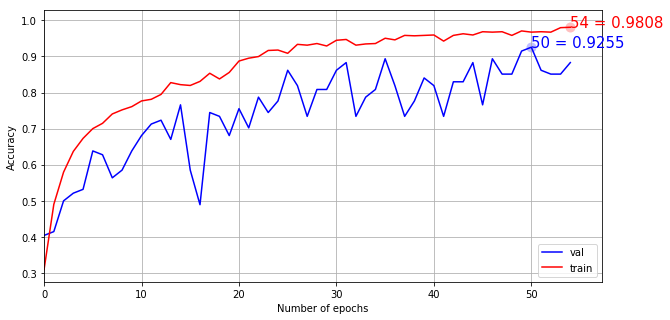

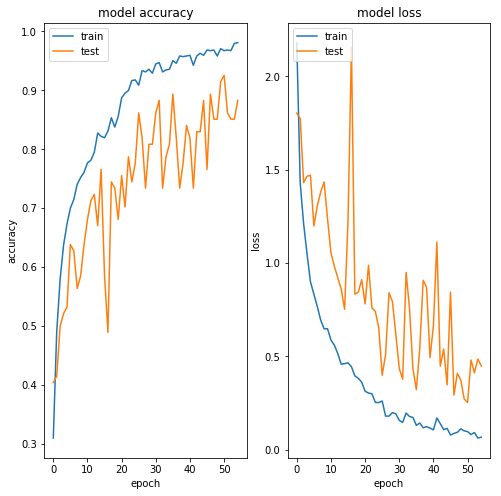

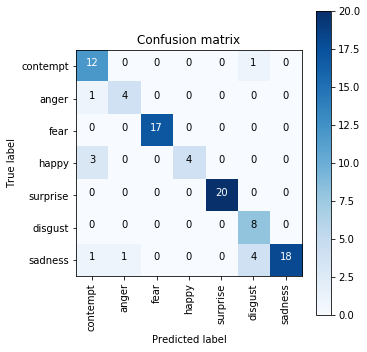

In [0]:
labels = map_characters1

# Evaluate model
 
score = model.evaluate(valid_X,valid_Y, verbose=0)
print('\n Model accuracy ON TEST SET :', score[1], '\n')
y_pred = model.predict(valid_X)
print('\n', sklearn.metrics.classification_report(np.where(valid_Y > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(valid_Y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plotKerasLearningCurve()
plt.show()
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
plt.show()


W0709 13:38:17.070414 140066030520192 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0709 13:38:17.093250 140066030520192 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0709 13:38:17.113902 140066030520192 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0709 13:38:17.135023 140066030520192 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0709 13:38:17.154366 140066030520192 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0709 13:38:17.174350 140066030520192 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0709 13:38:17.196120 140066

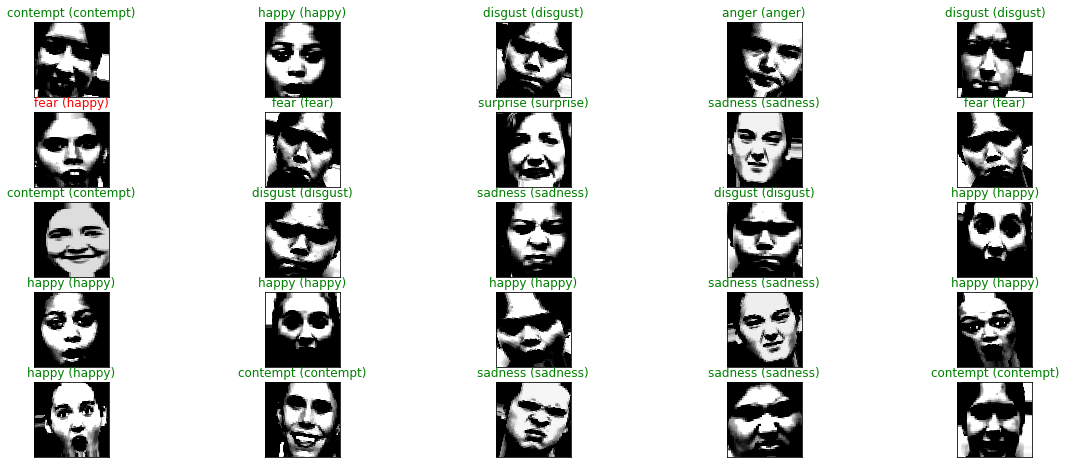

In [0]:
labelsFaces =['disgust', 'anger', 'sadness', 'surprise', 'contempt', 'fear', 'happy']


predictedExpression = model.predict(valid_X)

figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(valid_X.shape[0], size=25, replace=False)):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(valid_X[index]))
    predict_index = np.argmax(predictedExpression[index])
    true_index = np.argmax(valid_Y[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labelsFaces[predict_index], 
                                  labelsFaces[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()
import warnings
warnings.filterwarnings("ignore")


In [0]:
from keras.layers import Input
# defining inceptionnet model
def VGG16Model():
    img_in = Input(x_train.shape[1:])              #input of model 
    model =  VGG16(weights='imagenet',
                include_top= False , # remove  the 3 fully-connected layers at the top of the network
                      # pre train weight 
                input_tensor= img_in, 
                input_shape= x_train.shape[1:],
                pooling ='max') 
    x = model.output  
    predictions = Dense(7, activation="softmax", name="predictions")(x)    # fuly connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model
model = VGG16Model()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])


In [0]:
history=model.fit_generator(train_generator,
                            steps_per_epoch = 887/36,
                            validation_data = (valid_X,valid_Y), 
                            epochs = 55,
                            shuffle=True, 
                            callbacks = callbacks_list1+[MetricsCheckpoint('logs')])

                        

Epoch 1/55
25/24 [==============================] - 31s 1s/step - loss: 2.3007 - acc: 0.1952 - val_loss: 1.8296 - val_acc: 0.2553

Epoch 00001: val_acc did not improve from 0.25532
Epoch 2/55
25/24 [==============================] - 28s 1s/step - loss: 1.8388 - acc: 0.2497 - val_loss: 1.8269 - val_acc: 0.2766

Epoch 00002: val_acc improved from 0.25532 to 0.27660, saving model to weights.hdf5
Epoch 3/55
25/24 [==============================] - 28s 1s/step - loss: 1.8047 - acc: 0.2965 - val_loss: 1.8567 - val_acc: 0.1596

Epoch 00003: val_acc did not improve from 0.27660
Epoch 4/55
25/24 [==============================] - 28s 1s/step - loss: 1.7818 - acc: 0.3116 - val_loss: 1.8281 - val_acc: 0.3404

Epoch 00004: val_acc improved from 0.27660 to 0.34043, saving model to weights.hdf5
Epoch 5/55
25/24 [==============================] - 28s 1s/step - loss: 1.7607 - acc: 0.3312 - val_loss: 1.8344 - val_acc: 0.2447

Epoch 00005: val_acc did not improve from 0.34043
Epoch 6/55
25/24 [=========


 Model accuracy ON TEST SET : 0.8297872264334496 


              precision    recall  f1-score   support

    contempt       0.71      0.92      0.80        13
       anger       0.36      0.80      0.50         5
        fear       1.00      0.94      0.97        17
       happy       0.75      0.86      0.80         7
    surprise       1.00      0.70      0.82        20
     disgust       0.83      0.62      0.71         8
     sadness       0.95      0.88      0.91        24

    accuracy                           0.83        94
   macro avg       0.80      0.82      0.79        94
weighted avg       0.88      0.83      0.84        94



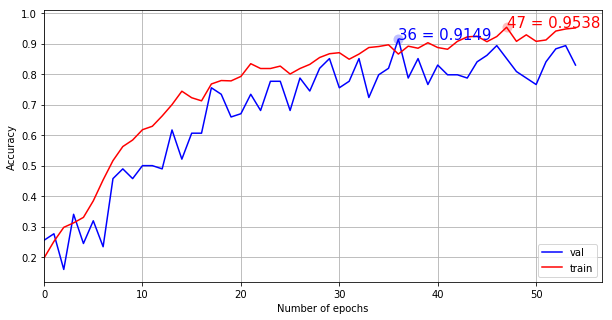

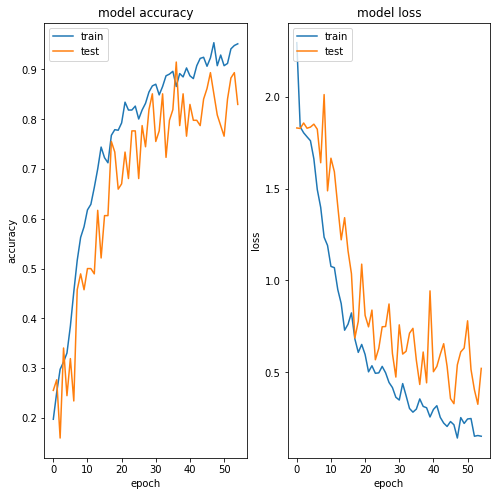

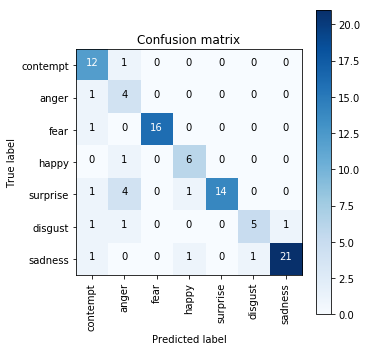

In [0]:
labels = map_characters1

# Evaluate model
 
score = model.evaluate(valid_X,valid_Y, verbose=0)
print('\n Model accuracy ON TEST SET :', score[1], '\n')
y_pred = model.predict(valid_X)
print('\n', sklearn.metrics.classification_report(np.where(valid_Y > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(valid_Y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plotKerasLearningCurve()
plt.show()
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
plt.show()


In [0]:
# defining inceptionnet model
from keras.layers import Input
from keras.applications.inception_v3 import InceptionV3

def inception_v3():
    img_in = Input(x_train.shape[1:])              #input of model 
    model =  InceptionV3(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= x_train.shape[1:],
                pooling ='avg') 
    x = model.output  
    predictions = Dense(7, activation="softmax", name="predictions")(x)    # fuly connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model
model = inception_v3()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

history=model.fit_generator(train_generator,
                            steps_per_epoch = 887/36,
                            validation_data = (valid_X,valid_Y), 
                            epochs = 55,
                            shuffle=True, 
                            callbacks = callbacks_list1+[MetricsCheckpoint('logs')])

                        

W0709 14:52:47.572683 140467797399424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



87916544/87910968 [==============================] - 3s 0us/step
Epoch 1/55
25/24 [==============================] - 41s 2s/step - loss: 1.7767 - acc: 0.4164 - val_loss: 4.0363 - val_acc: 0.3723

Epoch 00001: val_acc did not improve from 0.91489
Epoch 2/55
25/24 [==============================] - 20s 794ms/step - loss: 1.0211 - acc: 0.6295 - val_loss: 2.1965 - val_acc: 0.5638

Epoch 00002: val_acc did not improve from 0.91489
Epoch 3/55
25/24 [==============================] - 20s 792ms/step - loss: 0.7193 - acc: 0.7434 - val_loss: 2.4071 - val_acc: 0.6064

Epoch 00003: val_acc did not improve from 0.91489
Epoch 4/55
25/24 [==============================] - 20s 793ms/step - loss: 0.5184 - acc: 0.8047 - val_loss: 10.1719 - val_acc: 0.1809

Epoch 00004: val_acc did not improve from 0.91489
Epoch 5/55
25/24 [==============================] - 20s 791ms/step - loss: 0.3948 - acc: 0.8563 - val_loss: 4.7124 - val_acc: 0.5426

Epoch 00005: val_acc did not improve from 0.91489
Epoch 6/55
25/24 


 Inception pretrained model accuracy ON TEST SET : 0.9255319060163295 


              precision    recall  f1-score   support

    contempt       0.93      1.00      0.96        13
       anger       1.00      0.40      0.57         5
        fear       1.00      1.00      1.00        17
       happy       0.75      0.86      0.80         7
    surprise       0.82      0.90      0.86        20
     disgust       1.00      1.00      1.00         8
     sadness       1.00      0.96      0.98        24

    accuracy                           0.93        94
   macro avg       0.93      0.87      0.88        94
weighted avg       0.93      0.93      0.92        94



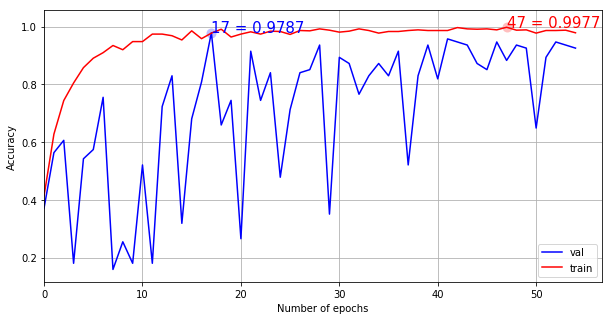

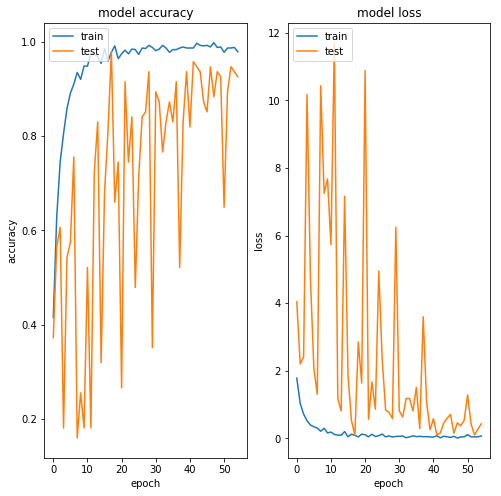

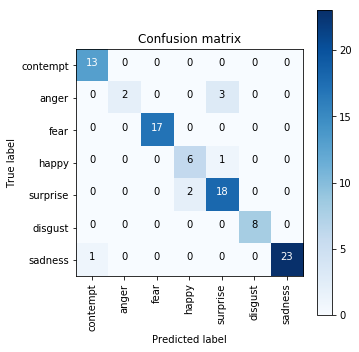

In [0]:
labels = map_characters1

# Evaluate model
 
score = model.evaluate(valid_X,valid_Y, verbose=0)
print('\n Inception pretrained model accuracy ON TEST SET :', score[1], '\n')
y_pred = model.predict(valid_X)
print('\n', sklearn.metrics.classification_report(np.where(valid_Y > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(valid_Y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plotKerasLearningCurve()
plt.show()
plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
plt.show()


# Machine learning

In [0]:

imageSize=10
test_dir = '../face/CK+48/'

# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['disgust']:
                label = 0
            elif folderName in ['anger']:
                label = 1
            elif folderName in ['sadness']:
                label = 2
            elif folderName in ['surprise']:
                label = 3
            elif folderName in ['contempt']:
                label = 4
            elif folderName in ['fear']:
                label = 5
            elif folderName in ['fear']:
                 label = 6
            else:
                label = 7

            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 1))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X) # Keras only accepts data as numpy arrays 
    y = np.asarray(y)
    return X,y
X_test, y_test = get_data(test_dir) # Un-comment to use full dataset: Step 1 of 2
#X_test, y_test= get_data(train_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) # comment this ligne  to use full dataset: Step 2 of 2


100%|██████████| 207/207 [00:00<00:00, 1011.19it/s]


In [0]:
m_samples = X_train.shape[0]
m_samplesTest = X_test.shape[0]
X_train1 = X_train.reshape(m_samples, -1)
X_test1 = X_test.reshape(m_samplesTest, -1)
 
print('Xtest shape',X_test1.shape)
print('X_train1 shape',X_train1.shape)
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)




Xtest shape (197, 100)
X_train1 shape (784, 100)
y_train shape (784,)
y_test shape (197,)


In [0]:
y_train

array([0, 2, 3, 0, 0, 3, 7, 3, 1, 1, 3, 0, 7, 2, 7, 3, 1, 7, 4, 7, 3, 1,
       7, 3, 1, 3, 2, 3, 5, 1, 3, 5, 4, 0, 2, 4, 0, 3, 7, 2, 3, 0, 3, 2,
       3, 0, 1, 1, 3, 0, 7, 0, 3, 5, 4, 7, 0, 7, 3, 3, 3, 3, 0, 4, 3, 2,
       1, 0, 7, 0, 3, 3, 5, 3, 3, 0, 0, 7, 0, 0, 3, 3, 5, 3, 7, 3, 2, 0,
       1, 0, 3, 7, 3, 7, 5, 3, 0, 7, 1, 0, 3, 3, 3, 4, 0, 3, 5, 0, 1, 5,
       7, 0, 0, 0, 7, 0, 0, 7, 3, 1, 2, 3, 7, 7, 5, 1, 1, 0, 7, 0, 5, 3,
       2, 7, 1, 2, 1, 0, 3, 3, 7, 0, 3, 5, 3, 0, 3, 1, 2, 3, 7, 0, 4, 7,
       3, 2, 1, 5, 1, 1, 1, 4, 7, 4, 7, 1, 3, 7, 3, 3, 7, 7, 0, 2, 4, 5,
       7, 4, 3, 0, 3, 7, 3, 1, 0, 2, 3, 1, 1, 4, 7, 7, 0, 5, 7, 7, 7, 7,
       3, 1, 1, 0, 3, 0, 3, 3, 7, 2, 3, 5, 7, 2, 1, 5, 3, 2, 7, 7, 3, 3,
       3, 7, 0, 0, 0, 7, 3, 0, 0, 5, 5, 7, 0, 3, 3, 2, 2, 0, 3, 2, 3, 3,
       1, 0, 0, 1, 3, 7, 1, 5, 5, 0, 7, 1, 0, 3, 7, 3, 7, 7, 7, 7, 2, 7,
       5, 7, 0, 4, 0, 7, 3, 4, 0, 0, 3, 0, 0, 3, 3, 7, 7, 3, 0, 0, 7, 5,
       1, 1, 3, 1, 3, 7, 5, 0, 2, 7, 1, 0, 7, 5, 5,

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import timeit

## XGBOOST classifier

In [0]:
start_time=time.time()
XGB = XGBClassifier()
XGB.fit(X_train1,y_train)


XGB_C = XGB.predict(X_test1)
print('\t\t\tPERFORMANCE\n')
print('Accuracy Obtained by XGBOOST  Classifier  :', round(accuracy_score(y_test, XGB_C), 4), '\n')
print("-training time %s seconds -" % (time.time() - start_time), '\n')
# classification_report(y_true,y_pred) Construire un rapport de texte montrant les métriques de classification principales
#renvoie un résumé textuel de la précision, du rappel, du score F1 pour chaque classe.
print(classification_report(y_test, XGB_C))
# Calcule la matrice de confusion pour évaluer l'exactitude d'une classification
cmatrix = confusion_matrix(y_test, XGB_C)

			PERFORMANCE

Accuracy Obtained by XGBOOST  Classifier  : 0.9594 

-training time 3.5447723865509033 seconds - 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.92      1.00      0.96        22
           2       0.92      0.86      0.89        14
           3       1.00      0.97      0.98        58
           4       1.00      1.00      1.00         9
           5       1.00      0.82      0.90        22
           7       0.90      1.00      0.95        44

    accuracy                           0.96       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.96      0.96       197



In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("XGBOOST  Accuracy ON CK48 data:",metrics.accuracy_score(y_test, y_predXG))
print('F1 score : ',f1_score(y_test,y_predXG,average="weighted"))
print('recall_score : ',recall_score(y_test,y_predXG,average="weighted"))
print('precision_score : ',precision_score(y_test,y_predXG,average="weighted"))

XGBOOST  Accuracy ON CK48 data: 0.9746192893401016
F1 score :  0.9744650520117476
recall_score :  0.9746192893401016
precision_score :  0.9754812757398716


In [0]:
def read_dataset(filename, mode=tf.contrib.learn.ModeKeys.EVAL,
                 batch_size=512, num_training_epochs=10):
  def
    
      
      # This is double indented to make a later edit simpler
      if mode == tf.contrib.learn.ModeKeys.TRAIN:
         num_epochs = num_training_epochs
      else:
         num_epochs = 1
      # could be a path to one file or a file pattern.
      input_file_names = tf.train.match_filenames_once(filename)
      filename_queue = tf.train.string_input_producer(
          input_file_names, num_epochs=num_epochs, shuffle=True)
      # Read in and parse the CSV
      reader = tf.TextLineReader()
      _, value = reader.read_up_to(
          filename_queue, num_records=batch_size)
      value_column = tf.expand_dims(value, -1)
      columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
      features = dict(zip(CSV_COLUMNS, columns))
      label = features.pop(LABEL_COLUMN)
      return features, label

## Decision trees classifier

In [0]:
start_time=time.time()
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
clf.fit(X_train1,y_train)


Dec_C = clf.predict(X_test1)
print('\t\t\tPERFORMANCE\n')
print('Accuracy Obtained by Decision Tree classifer  :', round(accuracy_score(y_test, Dec_C), 4), '\n')
print("-training time %s seconds -" % (time.time() - start_time), '\n')
# classification_report(y_true,y_pred) Construire un rapport de texte montrant les métriques de classification principales
#renvoie un résumé textuel de la précision, du rappel, du score F1 pour chaque classe.
print(classification_report(y_test, Dec_C))
# Calcule la matrice de confusion pour évaluer l'exactitude d'une classification
cmatrix = confusion_matrix(y_test, Dec_C)

			PERFORMANCE

Accuracy Obtained by Decision Tree classifer  : 0.8122 

-training time 0.056122779846191406 seconds - 

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.81      0.77      0.79        22
           2       0.50      0.50      0.50        14
           3       0.92      0.84      0.88        58
           4       0.44      0.78      0.56         9
           5       0.81      0.77      0.79        22
           7       0.87      0.91      0.89        44

    accuracy                           0.81       197
   macro avg       0.75      0.77      0.75       197
weighted avg       0.83      0.81      0.82       197



In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Decision tree Accuracy CK48 :",metrics.accuracy_score(y_test, y_pred))
print('F1 score : ',f1_score(y_test,y_pred,average="weighted"))
print('recall_score : ',recall_score(y_test,y_pred,average="weighted"))
print('precision_score : ',precision_score(y_test,y_pred,average="weighted"))

Decision tree Accuracy CK48 : 0.7766497461928934
F1 score :  0.776852503152032
recall_score :  0.7766497461928934
precision_score :  0.7882345573208518


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Random forest classifier

In [0]:
start_time=time.time()
from sklearn.ensemble import RandomForestClassifier
# Create Decision Tree classifer object
rf=RandomForestClassifier(n_estimators=300,class_weight='balanced',n_jobs=2,random_state=42)
rf.fit(X_train1,y_train)


RF_C = rf.predict(X_test1)
print('\t\t\tPERFORMANCE\n')
print('Accuracy Obtained by Decision Tree classifer  :', round(accuracy_score(y_test, RF_C), 4), '\n')
print("-training time %s seconds -" % (time.time() - start_time), '\n')
# classification_report(y_true,y_pred) Construire un rapport de texte montrant les métriques de classification principales
#renvoie un résumé textuel de la précision, du rappel, du score F1 pour chaque classe.
print(classification_report(y_test, RF_C))
# Calcule la matrice de confusion pour évaluer l'exactitude d'une classification
cmatrix = confusion_matrix(y_test, RF_C)

			PERFORMANCE

Accuracy Obtained by Decision Tree classifer  : 0.9695 

-training time 1.4644043445587158 seconds - 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        22
           2       0.82      1.00      0.90        14
           3       1.00      0.95      0.97        58
           4       1.00      1.00      1.00         9
           5       1.00      0.86      0.93        22
           7       0.94      1.00      0.97        44

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



In [0]:
print("Random Forest Classifier  Accuracy ON CK48 data:",metrics.accuracy_score(y_test, pred))
print('F1 score : ',f1_score(y_test,pred,average="weighted"))
print('recall_score : ',recall_score(y_test,pred,average="weighted"))
print('precision_score : ',precision_score(y_test,pred,average="weighted"))

Random Forest Classifier  Accuracy ON CK48 data: 0.9644670050761421
F1 score :  0.9636224636585405
recall_score :  0.9644670050761421
precision_score :  0.9665813928504285


## SVM classifier

In [0]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
# Create Decision Tree classifer object
classifier.fit(X_train1,y_train)
start_time=time.time()


SVM_C = classifier.predict(X_test1)
print('\t\t\tPERFORMANCE\n')
#print('Accuracy Obtained by Decision Tree classifer  :', round(accuracy_score(y_test, SVM_C), 4), '\n')
print("-training time %s seconds -" % (time.time() - start_time), '\n')
# classification_report(y_true,y_pred) Construire un rapport de texte montrant les métriques de classification principales
#renvoie un résumé textuel de la précision, du rappel, du score F1 pour chaque classe.
print(classification_report(y_test, SVM_C))
# Calcule la matrice de confusion pour évaluer l'exactitude d'une classification
cmatrix = confusion_matrix(y_test, SVM_C)

			PERFORMANCE

-training time 0.02221822738647461 seconds - 

              precision    recall  f1-score   support

           0       0.06      0.04      0.05        28
           1       1.00      0.05      0.09        22
           2       0.00      0.00      0.00        14
           3       0.59      0.97      0.73        58
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        22
           7       0.48      0.93      0.64        44

    accuracy                           0.50       197
   macro avg       0.30      0.28      0.21       197
weighted avg       0.40      0.50      0.37       197



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train1,y_train)

# Predicting the Test set results
y_predSVM = classifier.predict(X_test1)
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("SVM  Accuracy ON CK48 data:",metrics.accuracy_score(y_test, y_predSVM))
print('F1 score : ',f1_score(y_test,y_predSVM,average="weighted"))
print('recall_score : ',recall_score(y_test,y_predSVM,average="weighted"))
print('precision_score : ',precision_score(y_test,y_predSVM,average="weighted"))